In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.layers.experimental.preprocessing import *
import matplotlib.pyplot as plt
from hp import *

C:\Users\tom7l\anaconda3\envs\ai\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
num_classes = 100
input_shape = (32, 32, 3)
checkpoint_path = "C:\\Users\\tom7l\\ckpoint"
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [3]:
cropped_image = tf.image.crop_to_bounding_box(x_train[0], 0, 0, 31, 32)
padded_image = tf.image.pad_to_bounding_box(cropped_image, 0, 0, 32, 32)

In [4]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
a=tf.keras.preprocessing.image.random_shift(
    x_train[0],1, 0, row_axis=1, col_axis=2, channel_axis=0,
    fill_mode='nearest', cval=0.0, interpolation_order=1
)
a=tf.keras.preprocessing.image.random_shift(
    x_train[0],15, 0, row_axis=1, col_axis=2, channel_axis=0,
    fill_mode='nearest', cval=0.0, interpolation_order=1
)


print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [5]:
data_augmentation = keras.Sequential(
    [
        Normalization(),
        Resizing(image_size, image_size),
        RandomFlip("horizontal"),
        RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [6]:

def build_classifier(blocks, positional_encoding=False):
    inputs = layers.Input(shape=input_shape)
    

    # Augment data.
    augmented = data_augmentation(inputs)
    
    # Create patches.
    patches = Patches(patch_size, num_patches)(augmented)
    
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=embedding_dim)(patches)
    if positional_encoding:
        positions = tf.range(start=0, limit=num_patches, delta=1)
        position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=embedding_dim
        )(positions)
        x = x + position_embedding
    # Process x using the module blocks.
    x = blocks(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor.
    representation = layers.GlobalAveragePooling1D()(x)
    # Apply dropout.
    representation = layers.Dropout(rate=dropout_rate)(representation)
    # Compute logits outputs.
    logits = layers.Dense(num_classes)(representation)
    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=logits)

In [7]:
  
def run_experiment(model):
    # Create Adam optimizer with weight decay.
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,

        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
        ],
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    # Fit the model.
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[early_stopping, reduce_lr,cp_callback],
    )

    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    # Return history to plot learning curves.
    return history


In [8]:
from classes import MLPMixerLayer, Patches
mlpmixer_blocks = keras.Sequential(
    [MLPMixerLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)

model = build_classifier(mlpmixer_blocks)

# history = run_experiment(mlpmixer_classifier)

C:\Users\tom7l\anaconda3\envs\ai\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: Default value of `approximate` is changed from `True` to `False`
  return py_builtins.overload_of(f)(*args)


In [9]:
# load trained model

model.load_weights(checkpoint_path)
# Create Adam optimizer with weight decay.
optimizer = tfa.optimizers.AdamW(
    learning_rate=learning_rate, weight_decay=weight_decay,
)
# Compile the model.
model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="acc"),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
    ],
)
loss, acc, top5_acc = model.evaluate(x_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

313/313 - 16s - loss: 1.8927 - acc: 0.5058 - top5-acc: 0.7952
Restored model, accuracy: 50.58%


In [10]:
# from patch_test import *

img = x_test[165]
# # img=crop_with_direction(img,bottom=1)
# img=np.array(img)
img=img.reshape((1,32,32,3))
# y_test[0].reshape((1,1))
a=np.argmax(model.predict(img))
predict_mat = model.predict(img)[0]
# # print(predict_mat)
print(a)
second_max_idx =  np.argpartition(predict_mat.flatten(), -2)[-2:]
# second_max_value = predict_mat[second_max_idx][0]
print(second_max_idx[0])
# # model.evaluate(img.reshape((1,32,32,3)),y_test[15],verbose=2)

# print(x_test.shape)
# def find_smallest_diffs(k):
#     slice_object = slice(50)
#     # diffs = [None] * x_test.size
#     diffs = [None] * 50
#     for i, image in enumerate(x_test[slice_object]):
#         image = image.reshape((1,32,32,3))
#         # max=np.argmax(model.predict(image))
#         predict_matrix = model.predict(image)[0]
#         max_value = max(predict_matrix)
#         second_max_idx =  np.argpartition(predict_matrix.flatten(), -2)[-2:]
#         second_max_value = predict_matrix[second_max_idx][0]
#         diffs[i] = max_value-second_max_value
#     print(diffs)
#     slice_k = slice(k)
#     smallest_images = np.argpartition(diffs,k)[slice_k]
#     print(smallest_images)

# find_smallest_diffs(5)


96
47


In [15]:
from patch_test import *

def find_smallest_diffs_by_threshold(t):
    # slice_object = slice(200)
    # diffs = [None] * 200
    diffs = [None] * (x_test.size)
    below_threshold_images = []
    # for i, image in enumerate(x_test[slice_object]):
    for i, image in enumerate(x_test):
        image = image.reshape((1,32,32,3))
        predict_matrix = model.predict(image)[0]
        max_value = max(predict_matrix)
        second_max_idx =  np.argpartition(predict_matrix.flatten(), -2)[-2:]
        second_max_value = predict_matrix[second_max_idx][0]
        diffs[i] = max_value-second_max_value
        if(diffs[i] <= t):
            below_threshold_images.append(i)
    # print(diffs)
    # print(below_threshold_images)
    print(len(below_threshold_images))
    return below_threshold_images
    
below_threshold_images = find_smallest_diffs_by_threshold(0.2)


1150


In [12]:
def predict_diraction(image, direction, left=0, right=0, bottom=0, top=0):
    cropped=crop_with_direction(image,left=left, right=right, bottom=bottom, top=top)
    cropped = cropped.numpy()
    cropped=cropped.reshape((1,32,32,3))
    direction_predict = np.argmax(model.predict(cropped))
    print("{} crop predict: {}".format(direction, direction_predict))

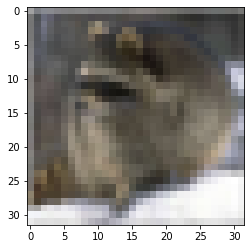

original predict: 97
left crop predict: 66
right crop predict: 66
bottom crop predict: 66
top crop predict: 66


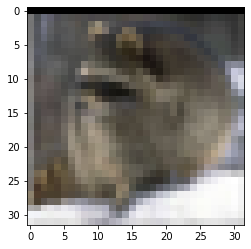

In [13]:
from patch_test import *
image = x_test[155]
# cropped_img = crop_with_direction(image, top=)
plt.imshow(image)
plt.show()

# m = nn.Softmax(dim=1)
# image = m(x_test[10])
# image=image.reshape((1,32,32,3))
# print(model.predict(image))

img=image.reshape((1,32,32,3))
# print(model.predict(img))
orig_predict = np.argmax(model.predict(img))
print("original predict: {}".format(orig_predict))

predict_diraction(image, "left", left=1)
predict_diraction(image, "right", right=1)
predict_diraction(image, "bottom", bottom=1)
predict_diraction(image, "top", top=1)


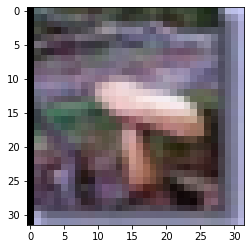

51
144/144 - 8s - loss: 2.9258 - acc: 0.2002 - top5-acc: 0.6304
Restored model, accuracy: 20.02%


In [31]:
all_cropped_images = []
for image in x_test[below_threshold_images]:
    left = crop_with_direction(image, left=1)
    right = crop_with_direction(image, right=1)
    bottom = crop_with_direction(image, bottom=1)
    top = crop_with_direction(image, top=1)
    all_cropped_images.extend([left, right, bottom, top])
y_test_repeated = np.repeat(y_test[below_threshold_images], 4)
x_test_cropped = np.array(all_cropped_images)
# plt.imshow(x_test_cropped[0])
# plt.show()
# print(y_test_repeated[0])

# loss, acc, top5_acc = model.evaluate(x_test_cropped, y_test_repeated, verbose=2)
# print("Restored model, accuracy: {:5.2f}%".format(100 * acc))


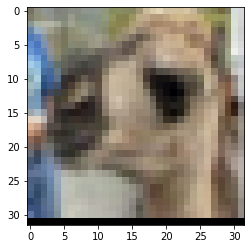

15
144/144 - 8s - loss: 2.9258 - acc: 0.2002 - top5-acc: 0.6304
model, accuracy: 20.02%


In [40]:
plt.imshow(x_test_cropped[130])
plt.show()
print(y_test_repeated[130])

loss, acc, top5_acc = model.evaluate(x_test_cropped, y_test_repeated, verbose=2)
print("model, accuracy: {:5.2f}%".format(100 * acc))